In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
from decimal import Decimal 
import datetime as dt

In [11]:
ord_items_df = pd.read_csv('/Users/Ian/Downloads/archive/order_items.csv')
ord_df = pd.read_csv('/Users/Ian/Downloads/archive/orders.csv')

In [4]:
f'Data ranges from: {df_ord_df.created_at.min()} to: {df_ord_df.created_at.max()}'

'Data ranges from: 2019-01-06 05:30:00+00:00 to: 2024-01-17 19:46:14.316147+00:00'

In [6]:
ord_items_df.sale_price.sum()

10827118.91175019

In [9]:
def data_cleaning(order_items_df, orders_df):
    '''
    This function takes the order_items and the orders tables, aggregates the order_items table,
    merges the tables, cleans the datatypes and returns the cleaned dataframe
    '''
    # Convert the created_at column from object to datetime
    
    order_sales = order_items_df[['order_id','sale_price']].groupby(by='order_id').sum('sale_price').reset_index()
    order_sales = order_sales.merge(orders_df[['order_id','user_id','created_at']]).set_index('order_id')
    
    order_sales['created_at'] = pd.to_datetime(order_sales.created_at,format='mixed')

    return order_sales

In [16]:
clean_df = data_cleaning(ord_items_df,ord_df)

In [13]:
def rfm(cleaned_order_items_df):
    '''
    This function takes the cleaned order_items dataframe and outputs the Recency, Frequency and Tenure dataframe
    '''
    return summary_data_from_transaction_data(transactions = cleaned_order_items_df,
                                              customer_id_col = 'user_id',
                                              datetime_col = 'created_at',
                                              monetary_value_col = 'sale_price')

The **recency** variable is a measure of the time elapsed since the customer’s last purchase.

The **frequency** corresponds to the number of orders placed by a customer.

The **monetary** metric shows the total revenue generated by each customer.

Tenure, or **T**, represents how long a given customer has been with the company.

In [110]:
clean_df.sort_values('user_id').head()

,sale_price,user_id,created_at
order_id,,,
1,159.990000,1,2022-07-18 12:55:00+00:00
2,22.000000,2,2022-02-20 10:34:00+00:00
3,59.990002,3,2023-04-23 09:13:00+00:00
4,108.750000,3,2023-08-08 09:13:00+00:00
5,109.989998,3,2023-03-10 09:13:00+00:00


In [164]:
def train_test_separation(df):

    time_diff = df.created_at.max() - df.created_at.min()  # work out how many days range in the dataset
    train_test_ratio = 0.25  # choose the fraction to use as test
    
    # work out the last date for the train dataset (the date to split the data)
    train_date_end = df.created_at.min() + time_diff * (1-train_test_ratio)

    # use the calibration_and_holdout_data method in lifetimes package to separate the time series data    
    separated_df = calibration_and_holdout_data(transactions=df, 
                                                customer_id_col="user_id",
                                                datetime_col = "created_at",
                                                monetary_value_col= 'sale_price',
                                                calibration_period_end=train_date_end,
                                                observation_period_end=df.created_at.max())

    return separated_df

In [165]:
train_df = train_test_separation(clean_df)

/Users/Ian/.pyenv/versions/lewagon/lib/python3.10/site-packages/lifetimes/utils.py:291: UserWarning: Converting to Period representation will drop timezone information.
  pd.to_datetime(observation_period_end, format=datetime_format).to_period(freq).to_timestamp()
/Users/Ian/.pyenv/versions/lewagon/lib/python3.10/site-packages/lifetimes/utils.py:203: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  transactions = transactions.set_index(datetime_col).to_period(freq).to_timestamp()
/Users/Ian/.pyenv/versions/lewagon/lib/python3.10/site-packages/lifetimes/utils.py:87: UserWarning: Converting to Period representation will drop timezone information.
  return d.to_period(freq)
/Users/Ian/.pyenv/versions/lewagon/lib/python3.10/site-packages/lifetimes/utils.py:87: UserWarning: Converting to Period representation will drop timezone information.
  return d.to_period(freq)


In [166]:
train_df

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
user_id,,,,,,,
1,0.0,0.0,89.0,0.0,0.0,0.000000,459.0
2,0.0,0.0,237.0,0.0,0.0,0.000000,459.0
6,0.0,0.0,190.0,0.0,0.0,0.000000,459.0
7,0.0,0.0,231.0,0.0,0.0,0.000000,459.0
8,0.0,0.0,457.0,0.0,0.0,0.000000,459.0
...,...,...,...,...,...,...,...
99983,1.0,177.0,215.0,46.0,2.0,189.974999,459.0
99990,0.0,0.0,776.0,0.0,0.0,0.000000,459.0
99992,0.0,0.0,70.0,0.0,0.0,0.000000,459.0


### Need to do model tuning

___

In [167]:
def train_model(rfm_train_df):
    pen_coef_ = 0.001
    model = BetaGeoFitter(penalizer_coef=pen_coef_)
    model.fit(rfm_train_df['frequency_cal'],
              rfm_train_df['recency_cal'],
              rfm_train_df['T_cal'])
    print("✅ Model initialized")
    return model

In [168]:
model = train_model(train_df)

✅ Model initialized


In [157]:
train_df

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
user_id,,,,,,,
1,0.0,0.0,89.0,0.0,0.0,0.000000,459.0
2,0.0,0.0,237.0,0.0,0.0,0.000000,459.0
6,0.0,0.0,190.0,0.0,0.0,0.000000,459.0
7,0.0,0.0,231.0,0.0,0.0,0.000000,459.0
8,0.0,0.0,457.0,0.0,0.0,0.000000,459.0
...,...,...,...,...,...,...,...
99983,1.0,177.0,215.0,46.0,2.0,189.974999,459.0
99990,0.0,0.0,776.0,0.0,0.0,0.000000,459.0
99992,0.0,0.0,70.0,0.0,0.0,0.000000,459.0


/Users/Ian/.pyenv/versions/lewagon/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:title={'center':'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

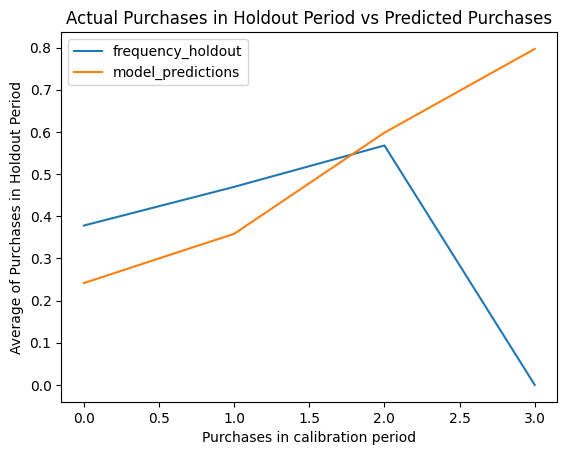

In [155]:
plot_calibration_purchases_vs_holdout_purchases(model,train_df)

In [123]:
rfm_df = rfm(clean_df)

/Users/Ian/.pyenv/versions/lewagon/lib/python3.10/site-packages/lifetimes/utils.py:287: UserWarning: Converting to Period representation will drop timezone information.
  pd.to_datetime(transactions[datetime_col].max(), format=datetime_format).to_period(freq).to_timestamp()
/Users/Ian/.pyenv/versions/lewagon/lib/python3.10/site-packages/lifetimes/utils.py:203: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  transactions = transactions.set_index(datetime_col).to_period(freq).to_timestamp()


In [127]:
# Predicting the number of purchases in the next 180 days for all customers.
rfm_df['predicted_purchases'] = model.conditional_expected_number_of_purchases_up_to_time(180,
                                                                                          rfm_df['frequency'], 
                                                                                          rfm_df['recency'], 
                                                                                          rfm_df['T'])


In [128]:
rfm_df_filtered = rfm_df[rfm_df.monetary_value>0]
gg_model = GammaGammaFitter()
gg_model.fit(rfm_df_filtered ['frequency'], rfm_df_filtered ['monetary_value']);

In [129]:
rfm_df['CLV'] = gg_model.customer_lifetime_value(model,
                                                 rfm_df['frequency'],
                                                 rfm_df['recency'],
                                                 rfm_df['T'],
                                                 rfm_df['monetary_value'],
                                                 time = 6,# In months
                                                )
rfm_df.sort_values('CLV')

,frequency,recency,T,monetary_value,predicted_purchases,CLV
user_id,,,,,,
37165,1.0,153.0,1711.0,11.950000,0.049507,2.811817
3131,1.0,152.0,1699.0,12.000000,0.049901,2.835149
41509,1.0,141.0,1674.0,15.990000,0.050365,2.935480
90133,1.0,100.0,1610.0,14.990000,0.051030,2.955432
66626,1.0,65.0,1522.0,9.630000,0.052954,2.962362
...,...,...,...,...,...,...
6513,2.0,17.0,98.0,545.500000,0.330380,108.633546
54607,2.0,130.0,278.0,644.485000,0.289672,110.535706
78682,3.0,242.0,363.0,434.786669,0.385971,116.666197


In [91]:
train_date_end

Timestamp('2022-07-18 06:09:22.773725088+0000', tz='UTC')

In [93]:
test_date_start

Timestamp('2022-07-18 06:09:22.773725104+0000', tz='UTC')